<a href="https://colab.research.google.com/github/kavyajeetbora/foursquare_ai/blob/master/notebooks/05_sql_qa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Question/Answering system over SQL data

[REFERENCE](https://python.langchain.com/docs/tutorials/sql_qa/)


## Architecture

At a high-level, the steps of these systems are:

1. **Convert question to SQL query**: Model converts user input to a SQL query.
2. **Execute SQL query**: Execute the query.
3. **Answer the question**: Model responds to user input using the query results.

Note that querying data in CSVs can follow a similar approach. See our [how-to guide](/docs/how_to/sql_csv) on question-answering over CSV data for more detail.

![sql_usecase.png](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/sql_usecase.png?raw=1)

## Setup

First, get required packages and set environment variables:

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langgraph langchain_openai

## Download the sql file that will be used to create the Database
!wget  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql -O Chinook_Sqlite.sql

## Create the Database

In [2]:
import sqlite3

# Name your database file
db_path = "Chinook.db"

# Connect (will create file if it doesn't exist)
conn = sqlite3.connect(db_path)

# Read your .sql file
with open("Chinook_Sqlite.sql", "r") as f:  # replace with your uploaded file name
    sql_script = f.read()

# Execute the entire SQL script at once
conn.executescript(sql_script)

# Commit & close
conn.commit()
conn.close()

print("Database created at", db_path)

Database created at Chinook.db


### Sample data

The below example will use a SQLite connection with the Chinook database, which is a sample database that represents a **digital media store**.

The database is structured to mimic real-world business scenarios, with tables representing the artists, albums, tracks, customers, and employees of a music shop.

Follow [these installation steps](https://database.guide/2-sample-databases-sqlite/) to create `Chinook.db` in the same directory as this notebook. You can also download and build the database via the command line:
```bash
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

Now, `Chinook.db` is in our directory and we can interface with it using the SQLAlchemy-driven `SQLDatabase` class:

[DB Diagram](https://dbdocs.io/nafawon167/ChinookDB?view=relationships)


Here is the diagram:

![Image](https://github.com/kavyajeetbora/foursquare_ai/blob/master/Chinook_DB.png?raw=true)

## Check the Database

In [3]:
# Reconnect to check tables
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:", cursor.fetchall())

conn.close()

Tables: [('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]


In [4]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print("Usable tables in the database:", db.get_usable_table_names())
db.run("SELECT * FROM Employee LIMIT 10;")

sqlite
Usable tables in the database: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'Adams', 'Andrew', 'General Manager', None, '1962-02-18 00:00:00', '2002-08-14 00:00:00', '11120 Jasper Ave NW', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'andrew@chinookcorp.com'), (2, 'Edwards', 'Nancy', 'Sales Manager', 1, '1958-12-08 00:00:00', '2002-05-01 00:00:00', '825 8 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 2T3', '+1 (403) 262-3443', '+1 (403) 262-3322', 'nancy@chinookcorp.com'), (3, 'Peacock', 'Jane', 'Sales Support Agent', 2, '1973-08-29 00:00:00', '2002-04-01 00:00:00', '1111 6 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 5M5', '+1 (403) 262-3443', '+1 (403) 262-6712', 'jane@chinookcorp.com'), (4, 'Park', 'Margaret', 'Sales Support Agent', 2, '1947-09-19 00:00:00', '2003-05-03 00:00:00', '683 10 Street SW', 'Calgary', 'AB', 'Canada', 'T2P 5G3', '+1 (403) 263-4423', '+1 (403) 263-4289', 'margaret@chinookcorp.com'), (5, 'Johnson', 'Steve', 'Sales Support Agent', 2, '1965-03-03 00:00:00', '2003-10-17 00:00:00', '7727B 41 Ave', 'Calgar

Great! We've got a SQL database that we can query. Now let's try hooking it up to an LLM.

## Chains {#chains}

Chains are compositions of predictable steps. In [LangGraph](/docs/concepts/architecture/#langgraph), we can represent a chain via simple sequence of nodes. Let's create a sequence of steps that, given a question, does the following:
- converts the question into a SQL query;
- executes the query;
- uses the result to answer the original question.

There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input-- even "hello". Importantly, as we'll see below, some questions require more than one query to answer. We will address these scenarios in the Agents section.

### Application state

The LangGraph [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a `TypedDict`, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/).

For this application, we can just keep track of the input question, generated query, query result, and generated answer:

Now we just need functions that operate on this state and populate its contents.

### Convert question to SQL query

The first step is to take the user input and convert it to a SQL query. To reliably obtain SQL queries (absent markdown formatting and explanations or clarifications), we will make use of LangChain's [structured output](/docs/concepts/structured_outputs/) abstraction.

Let's select a chat model for our application:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />


In [5]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path = '.env', override=True)

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

In [6]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

**Note**:

The **system message** in your ChatPromptTemplate is *included every time* you invoke the template for a user query (via .format() or in a chain), so it's passed with each request to the model—not just once at the start. This ensures consistency but watch token costs!

Let's provide some instructions for our model:

In [7]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's [SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) object includes methods to help with this.

### Step-by-step summary:

1. **Prompt Template**: You defined a `ChatPromptTemplate` with a system message (instructing the LLM to generate syntactically correct SQL queries for a given dialect, limited to `top_k` results, using specific table info) and a user prompt for the input question.

2. **Structured Output with TypedDict**: You used `QueryOutput` (a `TypedDict` with `query: Annotated[str, ..., "Syntactically valid SQL query."]`) to enforce structured LLM output as a dictionary (`{"query": str}`), ensuring predictable SQL generation.

3. **Pydantic Alternative**: We explored rewriting `QueryOutput` as a Pydantic `BaseModel` (`query: str = Field(..., description="...")`) for runtime validation. The `...` makes `query` required, preventing `None` or missing values, which is ideal for your chatbot.

4. **Write Query Function**: The `write_query` function:
   - Takes a `state` with the user’s question.
   - Populates the prompt template with dialect, `top_k`, table info, and question.
   - Uses `llm.with_structured_output(QueryOutput)` to force the LLM to output a `QueryOutput`-compliant dictionary.
   - Returns `{"query": result["query"]}` for database execution.

5. **Key Insight**: `with_structured_output` ensures the LLM doesn’t spit out random text, making your pipeline reliable. Pydantic’s required field (`...`) is recommended over optional fields for robust SQL query generation.

6. **Tech Stack**: You’re using LangChain (for chaining), LangGraph (for state), and LangSmith (for tracing)—a scalable combo. Pydantic is preferred over `typing_extensions` for validation and serialization.

**Next Steps**: Try implementing the Pydantic `QueryOutput` in your LangChain pipeline and test with a mock DB. Use LangSmith to debug any quirky LLM outputs. Want to code a quick example together? Let me know!


Our `write_query` step will just populate these parameters and prompt a model to generate the SQL query:

### First Define the Models

- this will handle the input and output format in structured way

In [8]:
from pydantic import BaseModel, Field

class State(BaseModel):
    question: str = ""
    query: str = ""  # Add defaults to make fields optional
    result: str = ""
    answer: str = ""

class QueryOutput(BaseModel):
    query: str = Field(..., description = "Syntactically valid SQL query.")

### Define each node/function

- generate query
- execute the query
- generate the answer based on user input, query and the result

In [9]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

# Write query (fixed earlier)
def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,  # Ensure db is defined
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state.question,
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)  # Ensure llm is defined
    result = structured_llm.invoke(prompt)
    return {"query": result.query}

# Execute query (fixed for attribute access)
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)  # Ensure db is defined
    return {"result": execute_query_tool.invoke(state.query)}  # Use state.query

# Generate answer (already correct)
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state.question}\n"
        f"SQL Query: {state.query}\n"
        f"SQL Result: {state.result}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

Let's test it out:

In [14]:
# Manual run
user_query = "Give me the top countries from where our customers come from?"
state = State(question=user_query)
generated_query = write_query(state)  # Returns {"query": "SELECT COUNT(*) FROM Employee;"}
print(f"Generated query: {generated_query['query']}")

# Pass State to execute_query
state = State(question=user_query, query=generated_query['query'])
result = execute_query(state)
print(f"Result: {result['result']}")

# Generate answer
state = State(question=user_query, query=generated_query['query'], result=result['result'])
ai_response = generate_answer(state)
print("\nAI Response:\n")
print("-"*100)
print(ai_response['answer'])

Generated query: SELECT Country, COUNT(*) as CustomerCount 
FROM Customer 
GROUP BY Country 
ORDER BY CustomerCount DESC 
LIMIT 10;
Result: [('USA', 13), ('Canada', 8), ('France', 5), ('Brazil', 5), ('Germany', 4), ('United Kingdom', 3), ('Portugal', 2), ('India', 2), ('Czech Republic', 2), ('Sweden', 1)]

AI Response:

----------------------------------------------------------------------------------------------------
The top countries from where our customers come from are:

1. USA - 13 customers
2. Canada - 8 customers
3. France - 5 customers
4. Brazil - 5 customers
5. Germany - 4 customers
6. United Kingdom - 3 customers
7. Portugal - 2 customers
8. India - 2 customers
9. Czech Republic - 2 customers
10. Sweden - 1 customer


### Orchestrating with LangGraph

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the three steps into a single sequence.

In [15]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display


# Graph setup
graph_builder = StateGraph(State)
graph_builder.add_sequence([write_query, execute_query, generate_answer])
graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()

In [21]:
# Invoke graph with stream
# question = "List the top buyers with their personal info, contry they belong to along with total number of orders?"
question = "Is there any customer named Hitesh? "
for step in graph.stream(
    {
        "question": question,
        "query": "",
        "result": "",
        "answer": ""
    },
    config={"configurable": {"thread_id": "1"}},
    stream_mode="updates"
):
    print(step)

print("-"*100,"\n")
print(step['generate_answer']['answer'])

{'write_query': {'query': "SELECT FirstName, LastName FROM Customer WHERE FirstName = 'Hitesh' LIMIT 10;"}}
{'execute_query': {'result': ''}}
{'generate_answer': {'answer': 'The SQL result is not provided, but based on the question and the SQL query, if the query returns any rows, it means there is at least one customer named Hitesh. If the query returns no rows, then there is no customer named Hitesh.\n\nTo answer the user question: \n\n- If the SQL result contains rows: Yes, there is a customer named Hitesh.\n- If the SQL result is empty: No, there is no customer named Hitesh.'}}
---------------------------------------------------------------------------------------------------- 

The SQL result is not provided, but based on the question and the SQL query, if the query returns any rows, it means there is at least one customer named Hitesh. If the query returns no rows, then there is no customer named Hitesh.

To answer the user question: 

- If the SQL result contains rows: Yes, ther

In [22]:
# Invoke graph to get final result
# question = "List the top buyers with their personal info, contry they belong to along with total number of orders?"
question = "Give me the top songs that were most played along with the artist name and number of times it was played"
final_state = graph.invoke(
    {
        "question": question,
        "query": "",
        "result": "",
        "answer": ""
    },
    config={"configurable": {"thread_id": "1"}}
)
print(final_state['answer'])

The top songs that were most played, along with the artist names and the number of times they were played, are as follows:

1. **Balls to the Wall** by **Accept** - Played 2 times
2. **Inject The Venom** by **AC/DC** - Played 2 times
3. **Snowballed** by **AC/DC** - Played 2 times
4. **Overdose** by **AC/DC** - Played 2 times
5. **Deuces Are Wild** by **Aerosmith** - Played 2 times
6. **Not The Doctor** by **Alanis Morissette** - Played 2 times
7. **Por Causa De Você** by **Antônio Carlos Jobim** - Played 2 times
8. **Welcome Home (Sanitarium)** by **Apocalyptica** - Played 2 times
9. **Snowblind** by **Black Sabbath** - Played 2 times
10. **Cornucopia** by **Black Sabbath** - Played 2 times

All of these songs were played 2 times each.


Check out the [LangSmith trace](https://smith.langchain.com/public/30a79380-6ba6-46af-8bd9-5d1df0b9ccca/r).

### Human-in-the-loop

LangGraph supports a number of features that can be useful for this workflow. One of them is [human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/): we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

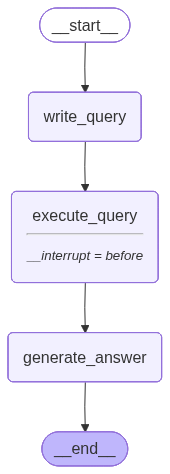

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

Let's repeat the same run, adding in a simple yes/no approval step:

In [ ]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}
Do you want to go to execute query? (yes/no): yes
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


See [this](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) LangGraph guide for more detail and examples.